In [34]:
import numpy as np
from scipy import misc, ndimage, spatial
from scipy.ndimage import morphology

from skimage import io, img_as_ubyte, img_as_float
from skimage.transform import rescale, hough_circle, hough_circle_peaks
from skimage.color import rgb2lab, lab2rgb, rgba2rgb
from skimage.io import imread, imsave, imshow, show, imshow_collection, imread_collection
from skimage import color, exposure, viewer, data
from skimage.util import invert, random_noise, montage
from skimage import filters, feature, morphology, segmentation
from skimage.draw import circle_perimeter
from skimage.morphology import thin

from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import webcolors

from copy import deepcopy

### Image Preprocessing

(407, 612, 3)


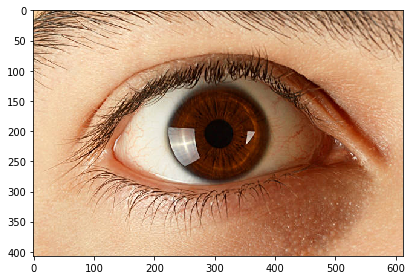

In [35]:
a = Image.open("brown/brown19.jpg")
test_img = np.asarray(a)
print(test_img.shape)
io.imshow(test_img)

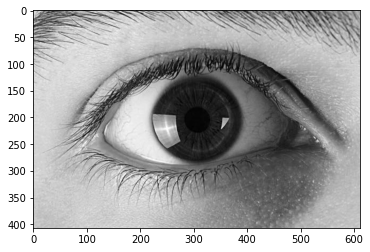

In [36]:
gray_img = color.rgb2gray(test_img)
plt.imshow(gray_img,cmap=plt.cm.gray)

In [37]:
gray_threshold = np.zeros(gray_img.shape)
mean = filters.threshold_minimum(gray_img)
gray_noiseless = filters.gaussian(gray_img, 1)
for i in range(gray_img.shape[0]):
    for j in range(gray_img.shape[1]):
        if gray_noiseless[i,j] > mean:
            gray_threshold[i,j] = 1

In [38]:
min_intensity = np.min(gray_noiseless)
if min_intensity < 0.1:
    thval =  0.05 + 2*min_intensity
else:
    thval = 0.05 + min_intensity
print(min_intensity)
img_th = gray_noiseless < thval

0.015221579190115873


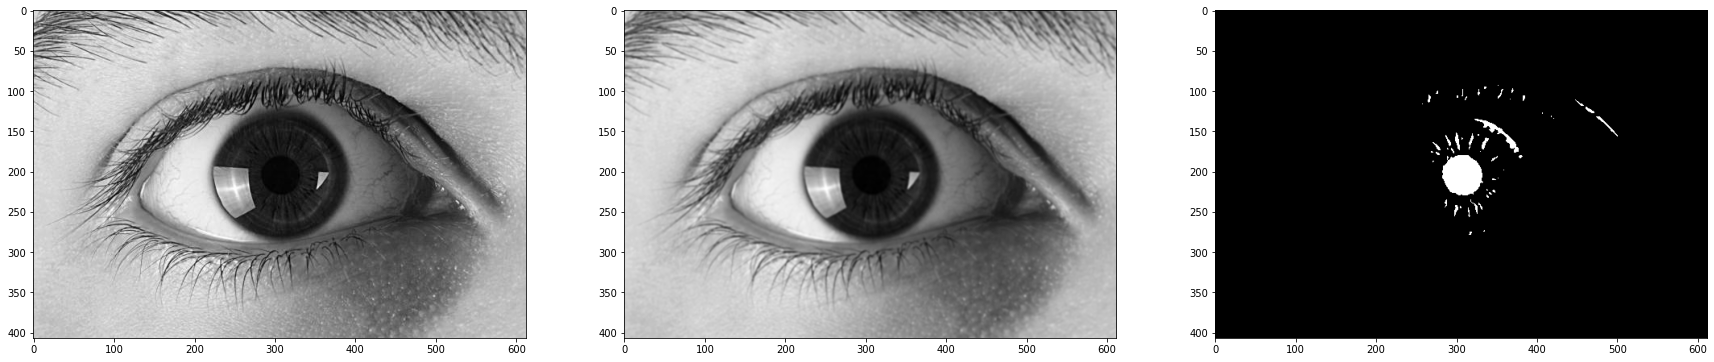

In [39]:
plt.figure(figsize=(30,10))
plt.subplot(131),plt.imshow(gray_img,cmap=plt.cm.gray)
plt.subplot(132),plt.imshow(gray_noiseless,cmap=plt.cm.gray)
plt.subplot(133),plt.imshow(img_th,cmap=plt.cm.gray)
plt.show()

### Detect the eye pupil

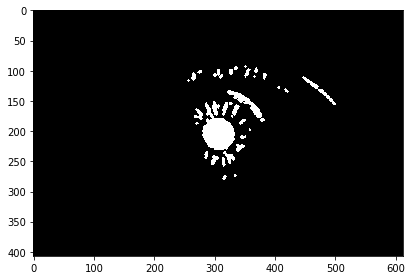

In [40]:
dilated_img = deepcopy(img_th)
for i in range(2):
    dilated_img = morphology.binary_dilation(dilated_img)

io.imshow(dilated_img)

tp  [192.45476959 317.01604805]
[181.40953918 328.03209611] 22.032096109019164 22.09046082123004 [203.5 306. ]


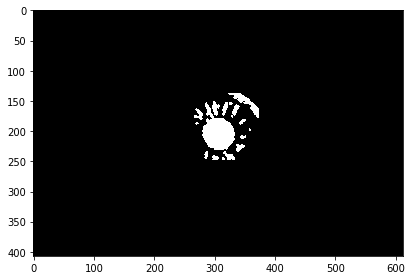

In [41]:
coords_dil = np.where(dilated_img == 1)
average = np.average(coords_dil,1)

#sh1 = img_th.shape[1]
#sh0 = img_th.shape[0]

#print(c1,border_coords)
center = np.array([img_th.shape[0]/2,img_th.shape[1]/2])
center_radius = np.abs(center[1]-average[1])
center_radius_x = np.abs(center[0]-average[0])

if center_radius < 10: center_radius = 0.2*img_th.shape[1]
if center_radius_x < 10: center_radius_x = 0.2*img_th.shape[0]

'''c2 = 0
ind2 = 0
use_this2 = False
for r in range(img_th.shape[1]-1,0,-1):
    if dilated_img[int(sh0)][r] and c2==0:
        c2 += 1
    elif not dilated_img[int(sh0)][r] and c2==1:
        ind2 = l
        c2 += 1
    elif dilated_img[int(sh0)][r] and c2==2:
        use_this2 = True
        break'''

turning_point = (center+average)/2
print("tp ",turning_point)

print(average,center_radius,center_radius_x,center)
#io.imshow(dilated_img)
for x in range(img_th.shape[0]):
    for y in range(img_th.shape[1]):
        if (x < turning_point[0] - 2.5*center_radius_x) or (x > turning_point[0] + 2.5*center_radius_x):
            dilated_img[x][y] = 0
        if (y < turning_point[1] - 2.5*center_radius) or (y > turning_point[1] + 2.5*center_radius):
            dilated_img[x][y] = 0
        
            
'''if use_this2:
    for x in range(sh0):
        for y in range(ind2):
            dilated_img[x][y] = 0'''

io.imshow(dilated_img)

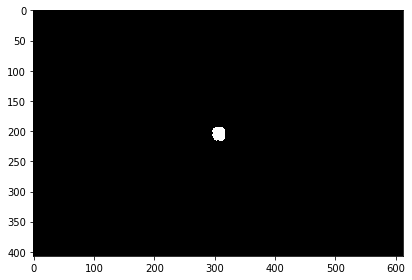

In [42]:
#perform circle hit-or-miss on a thresholded image to find pupil
disk = morphology.disk(2)
eroded = dilated_img
coords = np.where(eroded == 1)
while len(coords[0]) > 500:
    eroded = morphology.binary_erosion(eroded,disk)
    coords = np.where(eroded == 1)
io.imshow(eroded)

427 0
204.3185011709602 306.76112412177986
204 306 61 91
(122, 182, 3)


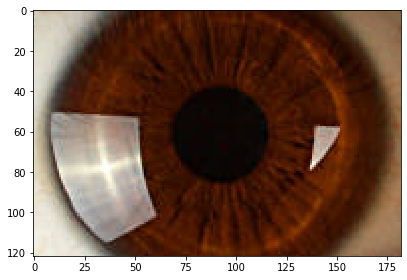

In [43]:
#find approximate position of pupil
group_a = []
group_b = []
for r in range(len(coords[0])):
    p = np.array([coords[0][r],coords[1][r]])
    if len(group_a) == 0:
        group_a.append(p)
    elif np.linalg.norm(np.average(group_a)-p) >= 0.25*test_img.shape[1]:
        group_b.append(p)
    else:
        group_a.append(p)
    
#print(group_a)
#print(len(group_b))
    
radx = int(0.15*test_img.shape[0])
rady = int(0.15*test_img.shape[1])

#xavg = int(np.floor(np.average(coords[0])))
#yavg = int(np.floor(np.average(coords[1])))
print(len(group_a),len(group_b))

a_avg_intensity = 0
for acoord in group_a:
    a_avg_intensity += gray_noiseless[acoord[0]][acoord[1]]

b_avg_intensity = 0
for bcoord in group_b:
    b_avg_intensity += gray_noiseless[bcoord[0]][bcoord[1]]

if len(group_a) == 0:
    avg_a = 2000
else:
    avg_a = a_avg_intensity/len(group_a)
if len(group_b) == 0:
    avg_b = 2000
else:
    avg_b = b_avg_intensity/len(group_b)


if avg_b > avg_a:
    xavg,yavg = np.average(group_a,0)
    print(xavg,yavg)
else:
    xavg,yavg = np.average(group_b,0)
xavg = int(np.floor(xavg))
yavg = int(np.floor(yavg))

'''tx,ty = xavg, yavg
while img_th[tx][yavg]:
    tx -= 1
rady = radx = int(1.5*np.abs(xavg-tx))'''

print(xavg,yavg,radx,rady)

coord1,coord2,coord3,coord4 = xavg-radx,xavg+radx,yavg-rady,yavg+rady
if coord1 < 0: coord1 = 0
if coord2 >= test_img.shape[0]: coord2 = test_img.shape[0]-1
if coord3 < 0: coord3 = 0
if coord4 >= test_img.shape[1]: coord4 = test_img.shape[1]-1

eye_img = test_img[coord1:coord2,coord3:coord4]
print(eye_img.shape)
io.imshow(eye_img)


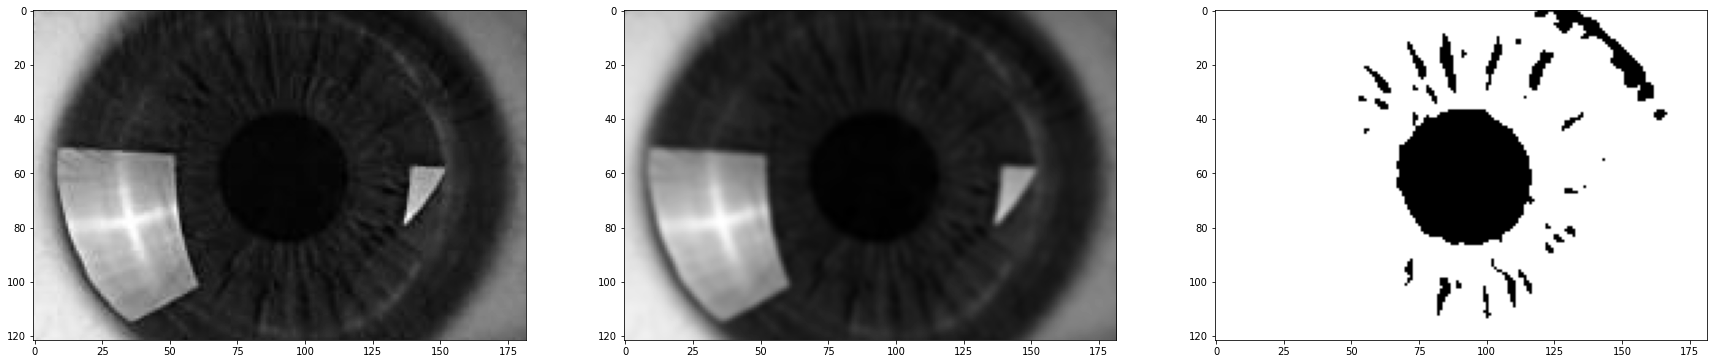

In [44]:
gray_eye = gray_img[coord1:coord2,coord3:coord4]
#eye_threshold = gray_threshold[xavg-100:xavg+100,yavg-100:yavg+100]
eye_noiseless = gray_noiseless[coord1:coord2,coord3:coord4]
eye_threshold = np.zeros(gray_eye.shape)
for i in range(gray_eye.shape[0]):
    for j in range(gray_eye.shape[1]):
        if eye_noiseless[i][j] > thval:
            eye_threshold[i][j] = 1

plt.figure(figsize=(30,10))
plt.subplot(131),plt.imshow(gray_eye,cmap=plt.cm.gray)
plt.subplot(132),plt.imshow(eye_noiseless,cmap=plt.cm.gray)
plt.subplot(133),plt.imshow(eye_threshold,cmap=plt.cm.gray)
plt.show()

[62] [92] [24]


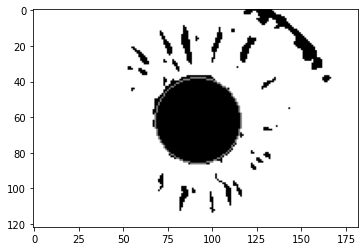

In [45]:
eyeEdges = feature.canny(eye_threshold)
a = eye_img.shape[0]
b = eye_img.shape[1]
houghRadii = np.arange(int(a/6),int(a/2), 2)
houghRes = hough_circle(eyeEdges, houghRadii)
accums, cx, cy, radii = hough_circle_peaks(houghRes, houghRadii, total_num_peaks=1)
fig, ax = plt.subplots(ncols=1, nrows=1)
image = deepcopy(eye_threshold)
print(cy,cx,radii)
for centerY, centerX, radius in zip(cy, cx, radii):
    if radius + centerX == image.shape[1] or radius + centerY == image.shape[0]:
        radius -= 1
    circx, circy = circle_perimeter(centerX, centerY, radius, shape=image.shape)
    image[circy, circx] = 0.5

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

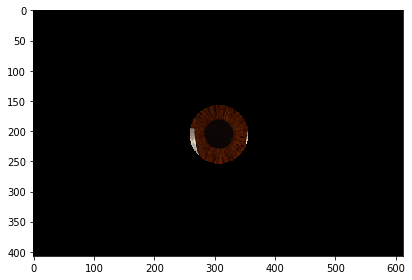

In [46]:
greatest_circle = 0
cxt = cy[greatest_circle] + xavg - radx
cyt = cx[greatest_circle] + yavg - rady

radi = radii[greatest_circle]*(test_img.shape[1]/eye_img.shape[1])

iris_img = deepcopy(test_img)
for i in range(test_img.shape[0]):
    for j in range(test_img.shape[1]):
        if np.linalg.norm(np.array([i,j])-np.array([cxt,cyt])) >= 0.6*radi:
            iris_img[i][j] = [0,0,0]

io.imshow(iris_img)

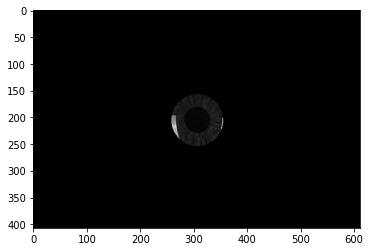

In [47]:
gray_iris = color.rgb2gray(iris_img)
plt.imshow(gray_iris,cmap=plt.cm.gray)

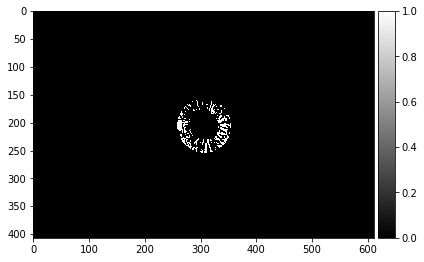

In [48]:
eye_threshold = deepcopy(gray_iris)
for i in range(test_img.shape[0]):
    for j in range(test_img.shape[1]):
        if gray_iris[i][j] < 0.12 or gray_iris[i][j] > 0.7:
            eye_threshold[i][j] = 0
        else:
            eye_threshold[i][j] = 1

io.imshow(eye_threshold,cmap=plt.cm.gray)

### Calculate average intensity of iris

[87.26280624 42.98942094 21.95489978]


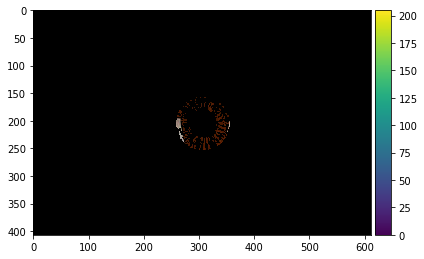

In [49]:
avg_colour = np.array([0,0,0])
count = 0
output_img = deepcopy(test_img)
for i in range(test_img.shape[0]):
    for j in range(test_img.shape[1]):
        if (eye_threshold[i][j]):
            avg_colour += test_img[i][j]
            count += 1
        else:
            output_img[i][j] = [0,0,0]

avg_colour = avg_colour/count
print(avg_colour)
io.imshow(output_img)

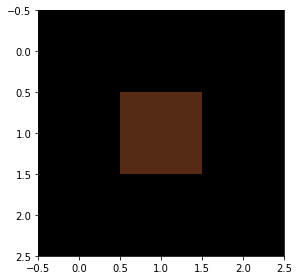

In [50]:
colour = np.zeros((3,3,3))
for i in range(len(avg_colour)):
    avg_colour[i] = avg_colour[i]/255
colour[1][1] = avg_colour
io.imshow(colour)

In [51]:
#predicts one of the six common iris colours from the average intensity of the iris.
def predict_eye_color(rgbval):
    con1,con2,con3 = 0 < np.abs(rgbval[0]-rgbval[1]) < 15,0 < np.abs(rgbval[1]-rgbval[2]) < 15,0 < np.abs(rgbval[0]-rgbval[2]) < 15
    con4 = rgbval[0] > 100 and rgbval[1] > 100 and rgbval[2] > 100
    if con1 and con2  and con3 and con4: #if gray is likely
        return "gray"
    elif rgbval[2] > rgbval[1] and rgbval[2] > rgbval[0]: #if blue component greater than red and green compeonents
        return "blue"
    elif rgbval[1] > rgbval[0] and rgbval[1] > rgbval[2]: #if green component is greater than the other two
        return "green"
    else: #if red component is greatest
        if rgbval[2] < 10 and rgbval[0] > 150:
            return "amber"
        elif rgbval[0] < 100 or rgbval[2] < 60 and rgbval[1] < 80:
            return "brown"
        else:
            return "hazel"

In [52]:
reqColour = []
for i in range(3):
    reqColour.append(int(np.floor(avg_colour[i]*256)))

#io.imshow(dilated_img)
colourName = predict_eye_color(reqColour)
print(reqColour,colourName)


[87, 43, 22] brown


In [53]:
'''coords_dil = np.where(dilated_img == 1)
average = np.average(coords_dil,1)

#find approximate position of pupil
group_adil = []
group_bdil = []
for r in range(len(coords_dil[0])):
    p = np.array([coords_dil[0][r],coords_dil[1][r]])
    if len(group_adil) == 0:
        group_adil.append(p)
    elif np.linalg.norm(np.average(group_adil)-p) >= 0.25*test_img.shape[1]:
        group_bdil.append(p)
    else:
        group_adil.append(p)

print(len(group_adil),len(group_bdil))
a_avg_intensityd = 0
for acoord in group_adil:
    if img_th[acoord[0]][acoord[1]]:
        a_avg_intensityd += gray_noiseless[acoord[0]][acoord[1]]

b_avg_intensityd = 0
for bcoord in group_bdil:
    if img_th[acoord[0]][acoord[1]]:
        b_avg_intensityd += gray_noiseless[bcoord[0]][bcoord[1]]

print(a_avg_intensityd,b_avg_intensityd)
if len(group_adil) == 0:
    avg_ad = 2000
else:
    avg_ad = a_avg_intensityd/len(group_adil)
if len(group_bdil) == 0:
    avg_bd = 2000
else:
    avg_bd = b_avg_intensityd/len(group_bdil)

print(avg_ad,avg_bd)
if avg_bd > avg_ad:
    for acd in group_bdil:
        dilated_img[acd[0]][acd[1]] = 0
else:
    for acd in group_adil:
        dilated_img[acd[0]][acd[1]] = 0

#io.imshow(dilated_img)
coords_dil = np.where(dilated_img == 1)
average = np.average(coords_dil,1)

#sh1 = img_th.shape[1]
#sh0 = img_th.shape[0]


#print(c1,border_coords)
center = np.array([img_th.shape[0]/2,img_th.shape[1]/2])
center_radius = np.abs(center[1]-average[1])
center_radius_x = np.abs(center[0]-average[0])

if center_radius < 10: center_radius = 0.2*img_th.shape[1]
if center_radius_x < 10: center_radius_x = 0.2*img_th.shape[0]

''''''c2 = 0
ind2 = 0
use_this2 = False
for r in range(img_th.shape[1]-1,0,-1):
    if dilated_img[int(sh0)][r] and c2==0:
        c2 += 1
    elif not dilated_img[int(sh0)][r] and c2==1:
        ind2 = l
        c2 += 1
    elif dilated_img[int(sh0)][r] and c2==2:
        use_this2 = True
        break'''

'''turning_point = (center+average)/2
print("tp ",turning_point)

print(average,center_radius,center_radius_x,center)
io.imshow(dilated_img)
for x in range(img_th.shape[0]):
    for y in range(img_th.shape[1]):
        if (x < turning_point[0] - 2.5*center_radius_x) or (x > turning_point[0] + 2.5*center_radius_x):
            dilated_img[x][y] = 0
        if (y < turning_point[1] - 2.5*center_radius) or (y > turning_point[1] + 2.5*center_radius):
            dilated_img[x][y] = 0'''
        
            
'''if use_this2:
    for x in range(sh0):
        for y in range(ind2):
            dilated_img[x][y] = 0'''



'if use_this2:\n    for x in range(sh0):\n        for y in range(ind2):\n            dilated_img[x][y] = 0'